In [1]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import glob
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import hsv_to_rgb
import seaborn as sns
import scipy.stats as stats
import subprocess

import qtl.plot
import qtl.annotation
import qtl.norm
import qtl.genotype as gt

import style

In [2]:
def s2d(x):
    """Get donor ID from sample ID"""
    if isinstance(x, str):
        return '-'.join(x.split('-')[:2])
    elif isinstance(x, Iterable):
        return ['-'.join(i.split('-')[:2]) for i in x]

annot = qtl.annotation.Annotation('data/gencode.v26.GRCh38.genes.gtf', verbose=False)
rnaseq_df = pd.read_csv('data/GTEx_Analysis_v8_RNAseq_samples.txt', sep='\t')
sample_s = rnaseq_df[rnaseq_df['has_genotype']].groupby('tissue_id').apply(lambda x: x['sample_id'].tolist())
sample_s = sample_s[sample_s.apply(len)>=70]
size_s = sample_s.apply(len)

egene_files = {os.path.basename(i).split('.')[0]:i for i in glob.glob('data/GTEx_Analysis_v8_eQTL/*.egenes.txt.gz')}
sgene_files = {os.path.basename(i).split('.')[0]:i for i in glob.glob('data/GTEx_Analysis_v8_sQTL/*.sgenes.txt.gz')}

indep_eqtl_files = {os.path.basename(i).split('.')[0]:i for i in glob.glob('data/GTEx_Analysis_v8_eQTL_independent/*.independent_eqtls.txt.gz')}
indep_sqtl_files = {os.path.basename(i).split('.')[0]:i for i in glob.glob('data/GTEx_Analysis_v8_sQTL_independent/*.independent_sqtls.txt.gz')}

tissues = sorted(egene_files)

### RNA-seq and WGS summary statistics

In [3]:
print('Total RNA-seq samples: {}'.format(rnaseq_df.shape[0]))
print('Total subjects: {}'.format(rnaseq_df['donor_id'].unique().shape[0]))
print('Total tissues: {}'.format(rnaseq_df['tissue_id'].unique().shape[0]))
print('Genotyped donors: {}'.format(rnaseq_df.loc[rnaseq_df['has_genotype'], 'donor_id'].unique().shape[0]))
print('RNA-seq samples with genotypes: {}'.format(rnaseq_df.loc[rnaseq_df['has_genotype']].shape[0]))
print('QTL samples: {}'.format(rnaseq_df.loc[rnaseq_df['has_genotype']].groupby('tissue_id').filter(lambda x: x.shape[0]>=70).shape[0]))

Total RNA-seq samples: 17382
Total subjects: 948
Total tissues: 54
Genotyped donors: 838
RNA-seq samples with genotypes: 15253
QTL samples: 15201


In [4]:
# vcf_stats = subprocess.check_output('bcftools stats GTEx_Analysis_2017-06-05_v8_WholeGenomeSeq_838Indiv_Analysis_Freeze.SHAPEIT2_phased.vcf.gz', shell=True).decode()
# SN	0	number of samples:	838
# SN	0	number of records:	46526292
# SN	0	number of no-ALTs:	0
# SN	0	number of SNPs:	43066422
# SN	0	number of MNPs:	0
# SN	0	number of indels:	3459870
# SN	0	number of others:	0
# SN	0	number of multiallelic sites:	0
# SN	0	number of multiallelic SNP sites:	0

# vcf_stats_maf01 = subprocess.check_output('bcftools stats GTEx_Analysis_2017-06-05_v8_WholeGenomeSeq_838Indiv_Analysis_Freeze.SHAPEIT2_phased.MAF01.vcf.gz', shell=True).decode()
# SN	0	number of samples:	838
# SN	0	number of records:	10770860
# SN	0	number of SNPs:	10008325
# SN	0	number of indels:	762535

### Panel 2A: QTL summary statistics

In [5]:
# summary table, using protein coding and lincRNA genes only
qtl_summary_df = pd.DataFrame(0, index=tissues, columns=[
    'samples', 'detected_genes', 'egenes', 'spliced_genes', 'sgenes'])
qtl_summary_df.index.name = 'tissue_id'
qtl_summary_df['samples'] = size_s

# proportions of genes with an eQTL/sQTL across tissues
eqtl_protein_s = pd.Series(0, index=[g.id for g in annot.genes if g.type=='protein_coding'])
eqtl_linc_s =    pd.Series(0, index=[g.id for g in annot.genes if g.type=='lincRNA'])
sqtl_protein_s = pd.Series(0, index=[g.id for g in annot.genes if g.type=='protein_coding'])
sqtl_linc_s =    pd.Series(0, index=[g.id for g in annot.genes if g.type=='lincRNA'])
prop_2x = []
for t in tissues:
    egenes_df = pd.read_csv(egene_files[t], sep='\t', index_col=0)
    egenes_df['biotype'] = egenes_df.index.map(lambda x: annot.gene_dict[x].type)
    egenes_df = egenes_df[egenes_df.biotype.isin(['protein_coding', 'lincRNA'])]
    qtl_summary_df.loc[t, 'detected_genes'] = egenes_df.shape[0]
    egenes_df = egenes_df[egenes_df['qval']<=0.05]
    qtl_summary_df.loc[t, 'egenes'] = egenes_df.shape[0]
    eqtl_protein_s[egenes_df[egenes_df['biotype']=='protein_coding'].index] += 1
    eqtl_linc_s[egenes_df[egenes_df['biotype']=='lincRNA'].index] += 1
    prop_2x.append(np.sum(egenes_df['log2_aFC'].abs()>1) / egenes_df.shape[0])

    sgenes_df = pd.read_csv(sgene_files[t], sep='\t', index_col=0)
    sgenes_df['biotype'] = sgenes_df['gene_id'].apply(lambda x: annot.gene_dict[x].type)
    sgenes_df = sgenes_df[sgenes_df.biotype.isin(['protein_coding', 'lincRNA'])]
    qtl_summary_df.loc[t, 'spliced_genes'] = sgenes_df.shape[0]
    sgenes_df = sgenes_df[sgenes_df['qval']<=0.05]
    qtl_summary_df.loc[t, 'sgenes'] = sgenes_df.shape[0]
    sqtl_protein_s[sgenes_df.loc[sgenes_df['biotype']=='protein_coding', 'gene_id']] += 1
    sqtl_linc_s[sgenes_df.loc[sgenes_df['biotype']=='lincRNA', 'gene_id']] += 1

print('Protein coding genes with an eQTL in at least one tissue: {} ({:.1f}%)'.format(np.sum(eqtl_protein_s>0), 100*np.sum(eqtl_protein_s>0)/eqtl_protein_s.shape[0]))
print('lincRNA genes with an eQTL in at least one tissue: {} ({:.1f}%)'.format(np.sum(eqtl_linc_s>0), 100*np.sum(eqtl_linc_s>0)/eqtl_linc_s.shape[0]))
print('Protein coding genes with an sQTL in at least one tissue: {} ({:.1f}%)'.format(np.sum(sqtl_protein_s>0), 100*np.sum(sqtl_protein_s>0)/sqtl_protein_s.shape[0]))
print('lincRNA genes with an sQTL in at least one tissue: {} ({:.1f}%)'.format(np.sum(sqtl_linc_s>0), 100*np.sum(sqtl_linc_s>0)/sqtl_linc_s.shape[0]))
print('Avg. proportion of eQTLs with > 2-fold effect on gene expression: {:.0f}%'.format(np.mean(prop_2x)*100))

Protein coding genes with an eQTL in at least one tissue: 18262 (94.7%)
lincRNA genes with an eQTL in at least one tissue: 5006 (67.3%)
Protein coding genes with an sQTL in at least one tissue: 12824 (66.5%)
lincRNA genes with an sQTL in at least one tissue: 1600 (21.5%)
Avg. proportion of eQTLs with > 2-fold effect on gene expression: 22%


Correlation between sample size and cis-QTL discovery:
cis-eQTLs: rho = 0.95
cis-sQTLs: rho = 0.92


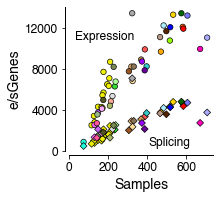

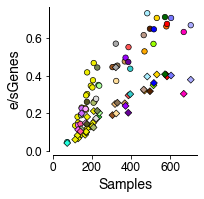

In [6]:
def plot_qtl_summary(qtl_summary_df, subtype='', normalized=False, ylim=None):

    colors = style.colors_df.loc[qtl_summary_df.index, 'color_hex']
    ax = qtl.plot.setup_figure(2,2,xspace=[1,0.25])
    if not normalized:
        ax.scatter(qtl_summary_df['samples'], 
                   qtl_summary_df['egenes'+subtype], 
                   c=colors, edgecolor='k', s=30, label='Expression', lw=0.66, clip_on=False)
        ax.scatter(qtl_summary_df['samples'],
                   qtl_summary_df['sgenes'+subtype],
                   c=colors, marker='D', s=24, edgecolor='k',
                   label='Splicing', alpha=1, lw=0.66, clip_on=False)
    else:
        ax.scatter(qtl_summary_df['samples'], 
                   qtl_summary_df['egenes'+subtype]/qtl_summary_df['detected_genes'+subtype], 
                   c=colors, edgecolor='k', s=30, label='Expression', lw=0.66, clip_on=False)
        ax.scatter(qtl_summary_df['samples'],
                   qtl_summary_df['sgenes'+subtype]/qtl_summary_df['spliced_genes'+subtype],
                   c=colors, marker='D', s=24, edgecolor='k',
                   label='Splicing', alpha=1, lw=0.66, clip_on=False)

    qtl.plot.format_plot(ax, fontsize=12)
    if ylim is None:
        ax.set_ylim([0, ax.get_ylim()[1]])
    else:
        ax.set_ylim(ylim)
    ax.yaxis.set_major_locator(ticker.MaxNLocator(min_n_ticks=4, nbins=4))
    ax.set_xlim([0, ax.get_xlim()[1]])
    
    ax.spines['bottom'].set_position(('outward', 4))
    ax.spines['left'].set_position(('outward', 4))
    ax.set_xlabel('Samples', fontsize=14)
    ax.set_ylabel('e/sGenes', fontsize=14)
    return ax
    
ax = plot_qtl_summary(qtl_summary_df)
ax.text(0.45, 0.75, 'Expression', ha='right', va='bottom', fontsize=12, transform=ax.transAxes)
ax.text(0.55, 0.1, 'Splicing', ha='left', va='top', fontsize=12, transform=ax.transAxes)
plt.savefig('pdfs/Fig2A_QTL_summary.pdf')
ax = plot_qtl_summary(qtl_summary_df, normalized=True)

print('Correlation between sample size and cis-QTL discovery:')
print('cis-eQTLs: rho = {:.2f}'.format(stats.spearmanr(qtl_summary_df['egenes']/qtl_summary_df['detected_genes'], qtl_summary_df['samples'])[0]))
print('cis-sQTLs: rho = {:.2f}'.format(stats.spearmanr(qtl_summary_df['sgenes']/qtl_summary_df['spliced_genes'],  qtl_summary_df['samples'])[0]))

### Panel 2B: Allelic heterogeneity

In [7]:
def plot_ah_summary(summary_df, prefix='e', width=0.9):

    ratio_df = (summary_df[summary_df.columns[:4]].T / summary_df['{}Genes'.format(prefix)]).T
    
    ax = qtl.plot.setup_figure(4,2,xspace=[0.75,0.75])
    c = summary_df.columns[:4][::-1]
    ratio_df[c].plot(kind='bar', stacked=True, ax=ax, width=width, color=sns.color_palette("Blues_r", 4))

    mean_color = hsv_to_rgb([0.02,0.8,0.8])
    ax2 = ax.twinx()
    x = np.arange(summary_df.shape[0])
    ax2.plot(x, summary_df['mean'], '.', c=mean_color, label='Mean')
    ax2.spines['right'].set_color(mean_color)
    ax2.tick_params(axis='y', colors=mean_color)

    qtl.plot.format_plot(ax, fontsize=12)
    qtl.plot.format_plot(ax2, fontsize=12, hide=['left', 'top', 'bottom'])
    ax2.set_ylim([1,2])
    ax.set_ylabel('Proportion of {}Genes'.format(prefix), fontsize=14)
    ax2.set_ylabel('Mean {}QTLs/gene'.format(prefix), fontsize=14, labelpad=8)#, c=mean_color)

    ylim = [0,14000]
    ylim = [0,1]
    d = ylim[1]-ylim[0]
    s = 1.06
    b = ylim[1] - s*d
    ax.set_ylim(ylim)
    ax.tick_params(axis='x', which='major', pad=10, labelsize=10)

    ax.scatter(x, b*np.ones(summary_df.shape[0]),
               s=20,
               c=style.colors_df.loc[summary_df.index, 'color_hex'], clip_on=False)
    ax.spines['left'].set_position(('outward', 4))
    ax2.spines['right'].set_position(('outward', 4))
    ax.spines['bottom'].set_bounds([-width/2, summary_df.shape[0]-1+width/2])
    ax.set_xlim([-0.66, summary_df.shape[0]-1+0.66])
    
    h1,_ = ax.get_legend_handles_labels()
    h2,_ = ax2.get_legend_handles_labels()
    h = h2 + h1
    labels = ['1', '2', '3', '≥ 4', 'Mean']
    h = h1
    labels = ['1', '2', '3', '≥ 4']
    ax.legend(h[::-1], labels, loc='upper left', title='{}QTLs/gene'.format(prefix),
             labelspacing=0.33, handletextpad=0.5)

    ax.set_xticklabels(style.colors_df.loc[summary_df.index, 'tissue_abbrv'],
                       rotation=-90, ha='center', fontsize=6)

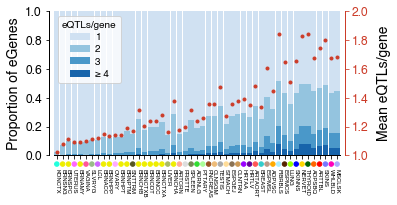

In [8]:
cols = ['1', '2', '3', 'geq4']
indep_eqtl_summary_df = pd.DataFrame(index=tissues, columns=cols+['mean'])
for t in tissues:
    indep_df = pd.read_csv(indep_eqtl_files[t], sep='\t')
    indep_df['biotype'] = indep_df['gene_id'].apply(lambda x: annot.gene_dict[x].type)
    indep_df = indep_df[indep_df['biotype'].isin(['protein_coding', 'lincRNA'])]
    num_indep_s = indep_df['gene_id'].value_counts()
    indep_eqtl_summary_df.loc[t, cols] = np.histogram(num_indep_s, [1,2,3,4,np.maximum(4,num_indep_s.max())+1])[0]
    indep_eqtl_summary_df.loc[t, 'mean'] = num_indep_s.mean()
indep_eqtl_summary_df['num_samples'] = size_s
indep_eqtl_summary_df = indep_eqtl_summary_df.sort_values('num_samples')
indep_eqtl_summary_df['eGenes'] = indep_eqtl_summary_df[indep_eqtl_summary_df.columns[:4]].sum(axis=1).astype(int)

plot_ah_summary(indep_eqtl_summary_df, prefix='e')
plt.savefig('pdfs/Fig2B_eQTL_indep_summary.pdf')

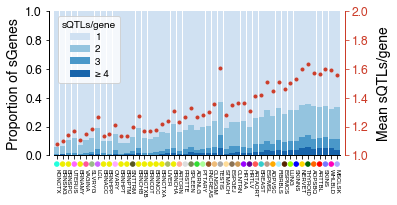

In [9]:
indep_sqtl_summary_df = pd.DataFrame(index=tissues, columns=cols+['mean'])
for t in tissues:
    indep_df = pd.read_csv(indep_sqtl_files[t], sep='\t')
    indep_df['biotype'] = indep_df['group_id'].apply(lambda x: annot.gene_dict[x].type)
    indep_df = indep_df[indep_df['biotype'].isin(['protein_coding', 'lincRNA'])]
    num_indep_s = indep_df['group_id'].value_counts()
    indep_sqtl_summary_df.loc[t, cols] = np.histogram(num_indep_s, [1,2,3,4,np.maximum(4,num_indep_s.max())+1])[0]
    indep_sqtl_summary_df.loc[t, 'mean'] = num_indep_s.mean()
indep_sqtl_summary_df['num_samples'] = size_s
indep_sqtl_summary_df = indep_sqtl_summary_df.sort_values('num_samples')
indep_sqtl_summary_df['sGenes'] = indep_sqtl_summary_df[indep_sqtl_summary_df.columns[:4]].sum(axis=1).astype(int)
plot_ah_summary(indep_sqtl_summary_df, prefix='s')
plt.savefig('pdfs/sQTL_indep_summary.pdf')

### Panel 2C: *trans*-eQTLs

In [10]:
cis_s = qtl_summary_df['egenes']
cis_s.name = 'cis_egenes'

trans_df = pd.read_csv('data/GTEx_Analysis_v8_trans_eGenes_fdr05.txt', sep='\t')
trans_s = trans_df['tissue_id'].value_counts()
trans_s.name = 'trans_egenes'

print('Total trans-eGenes across tissues: {}'.format((trans_df['tissue_id'] + ',' + trans_df['gene_id']).unique().shape[0]))
print('Unique trans-eGenes: {}'.format(trans_df['gene_id'].unique().shape[0]))

Total trans-eGenes across tissues: 162
Unique trans-eGenes: 143


Spearman rho for trans-eGenes vs sample size: 0.68
Spearman rho for trans-eGenes vs cis-eGenes:  0.77


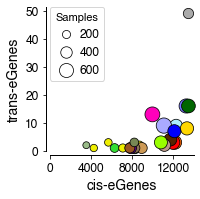

In [11]:
ix = np.intersect1d(cis_s.index, trans_s.index)

ax = qtl.plot.setup_figure(2,2,xspace=[1,0.25])
ax.scatter(cis_s[ix], trans_s[ix], s=0.33*qtl_summary_df.loc[ix, 'samples'],
           c=style.colors_df.loc[ix,'color_hex'], edgecolor='k', lw=0.75, clip_on=False)

ax.set_xlim([0, ax.get_xlim()[1]])
ax.set_ylim([0, ax.get_ylim()[1]])
ax.xaxis.set_major_locator(ticker.MaxNLocator(min_n_ticks=4, nbins=4))
ax.autoscale(True)
qtl.plot.format_plot(ax, fontsize=12)

ax.spines['bottom'].set_position(('outward', 4))
ax.spines['left'].set_position(('outward', 4))

ax.set_xlabel('cis-eGenes', fontsize=14)
ax.set_ylabel('trans-eGenes', fontsize=14)

ms = np.arange(200, 800, 200)
lg = [ax.scatter([],[], s=0.33*m, c='w', lw=0.75, edgecolor='k') for m in ms]

leg = ax.legend(lg, ms, fontsize=12, labelspacing=None, handletextpad=0.1,
    handlelength=2, loc='upper left', title='Samples', borderpad=None, borderaxespad=0)
leg.set_title('Samples',prop={'size':11})

plt.savefig('pdfs/Fig2C_eGenes_cis_vs_trans.scatter.pdf')

trans_s2 = pd.concat([trans_s, pd.Series(0, cis_s.index[~cis_s.index.isin(trans_s.index)])])
trans_s2.name = 'trans_egenes'
print('Spearman rho for trans-eGenes vs sample size: {:.2f}'.format(stats.spearmanr(qtl_summary_df['samples'], trans_s2[qtl_summary_df.index])[0]))
print('Spearman rho for trans-eGenes vs cis-eGenes:  {:.2f}'.format(stats.spearmanr(cis_s, trans_s2[cis_s.index])[0]))

### Panel 2D: sex-biased eQTL example

In [12]:
vcf = 'data/GTEx_Analysis_2017-06-05_v8_WholeGenomeSeq_838Indiv_Analysis_Freeze.SHAPEIT2_phased.vcf.gz'
vcf = str(Path(vcf).resolve())
assert os.path.exists(vcf+'.tbi')

In [13]:
tissue_id = 'Muscle_Skeletal'
covariates_df = pd.read_csv('/xchip/gtex/resources/V8_release/GTEx_Analysis_v8_eQTL_covariates/{}.v8.covariates.txt'.format(tissue_id),
                            sep='\t', index_col=0).T
sex_s = covariates_df['sex'].astype(int).map({1:'Male', 2:'Female'})
sex_s.name = 'sex'
covariates_df.drop('sex', axis=1, inplace=True)

# load TPM, apply size factor normalization
tpm_df = pd.read_csv('data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz',
                     sep='\t', skiprows=2, usecols=['Name']+sample_s[tissue_id], index_col=0)
tpm_df.rename(columns=s2d, inplace=True)
tpm_df = tpm_df / qtl.norm.deseq2_size_factors(tpm_df)

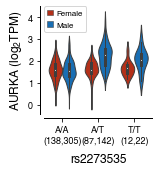

In [14]:
variant_id = 'chr20_56386485_A_T_b38'
rs_id = 'rs2273535'
gene_id = 'ENSG00000087586.17'  # AURKA
gene_name = annot.gene_dict[gene_id].name

g = gt.get_genotype(variant_id, vcf)[tpm_df.columns]
g.name = 'genotype'
p = np.log2(tpm_df.loc[gene_id])
p.name = 'phenotype'

ax = qtl.plot.setup_figure(1.5, 1.5)
qtl.plot.plot_qtl(g, p, ax=ax, label_s=sex_s, split=True, 
                  variant_id=variant_id, loc=2, covariates_df=covariates_df,
                  ylabel=gene_name+' (log$\mathregular{_{2}}$TPM)', xlabel=rs_id)
ax.spines['bottom'].set_position(('outward', 4))
ax.spines['left'].set_position(('outward', 4))
leg = ax.legend(fontsize=8, labelspacing=None, handletextpad=0.5,
                handlelength=2/3, loc='upper left', borderpad=None, borderaxespad=0)

plt.savefig('pdfs/Fig2D_AURKA_rs2273535_sex_eQTL.pdf')

### Panel 2E: population-biased eQTL example

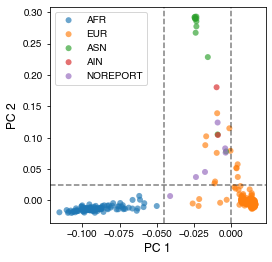

In [15]:
pc_df = pd.read_csv('/xchip/gtex/dbGaP/exchange/analysis_releases/GTEx_Analysis_2017-06-05_v8/genotypes/WGS/variant_calls/GTEx_Analysis_2017-06-05_v8_WholeGenomeSeq_support_files/GTEx_Analysis_2017-06-05_v8_WholeGenomeSeq_838Indiv_Analysis_Freeze_20genotPCs.txt', sep='\t', index_col=0)
pc_df.drop('IID', axis=1, inplace=True)
pc_df.rename(index=s2d, inplace=True)

subject_df = pd.read_csv('/xchip/gtex/resources/V8_release/sample_attributes/GTEx_Analysis_2017-06-05_v8_Annotations_SubjectPhenotypesDS.txt', sep='\t', index_col=0)
subject_df['RACE'] = subject_df['RACE'].map({1:'ASN', 2:'AFR', 3:'EUR', 4:'AIN', 99:'NOREPORT'})
pc_df = pc_df.join(subject_df['RACE'])

ax = qtl.plot.setup_figure(3,3)
for i in pc_df['RACE'].unique():
    ix = pc_df['RACE'][pc_df['RACE']==i].index
    ax.scatter(pc_df.loc[ix, 'PC1'], pc_df.loc[ix, 'PC2'], edgecolor='none', alpha=0.66, label=i)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.plot([-0.045]*2, ylim, 'k--', alpha=0.5)
ax.plot(xlim, [0.025]*2, 'k--', alpha=0.5)
ax.plot([0]*2, ylim, 'k--', alpha=0.5)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.legend()
ax.set_xlabel('PC 1', fontsize=12)
ax.set_ylabel('PC 2', fontsize=12);

In [16]:
pc_df.loc[pc_df['PC1'] < -0.045, 'population'] = 'AA'
pc_df.loc[(pc_df['PC1'] > 0) & (pc_df['PC2'] < 0.025), 'population'] = 'EA'
pop_s = pc_df['population']
pop_s = pop_s[pop_s.notnull()]
pop_s.value_counts()

EA    698
AA    103
Name: population, dtype: int64

In [17]:
tissue_id = 'Esophagus_Mucosa'
# load TPM, apply size factor normalization
tpm_df = pd.read_csv('data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz',
                     sep='\t', skiprows=2, usecols=['Name']+sample_s[tissue_id], index_col=0)
tpm_df.rename(columns=s2d, inplace=True)
tpm_df = tpm_df / qtl.norm.deseq2_size_factors(tpm_df)

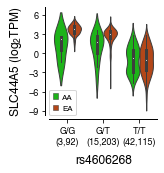

In [18]:
gene_name = 'SLC44A5'
gene_id = annot.get_gene(gene_name).id
variant_id = 'chr1_75386753_G_T_b38'
rs_id = 'rs4606268'

m = tpm_df.columns.isin(pop_s.index) & (tpm_df.loc[gene_id]>0)
ix = m[m].index

g = gt.get_genotype(variant_id, vcf)[ix]
g.name = 'genotype'

p = np.log2(tpm_df.loc[gene_id, ix])
p.name = 'phenotype'

split_colors = [
    hsv_to_rgb([0.33, 1, 0.8]),
    hsv_to_rgb([0.05, 1, 0.8]),
]

ax = qtl.plot.setup_figure(1.5, 1.5, xspace=[0.75, 0.75])
qtl.plot.plot_qtl(g, p, ax=ax, label_s=pop_s, split=True, split_colors=split_colors,
                  covariates_df=None, variant_id=variant_id, loc=4,
                  ylabel=gene_name+' (log$\mathregular{_{2}}$TPM)', xlabel=rs_id)
ax.spines['bottom'].set_position(('outward', 4))
ax.spines['left'].set_position(('outward', 4))
leg = ax.legend(fontsize=8, labelspacing=None, handletextpad=0.5,
                handlelength=2/3, loc='lower left', borderpad=None, borderaxespad=0)

plt.savefig('pdfs/Fig2E_{}_{}_population_eQTL.pdf'.format(gene_name, rs_id))